In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from sklearn.metrics import roc_auc_score

from importlib import reload
import matplotlib.pyplot as plt

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.eval as ev
import model_params as params
import utils.resnet_orig as resnet
import utils.gmm_helpers as gmm_helpers

from tensorboardX import SummaryWriter
%load_ext line_profiler

In [2]:
def get_auroc(model_list, model_params, stats, device):
    auroc = []
    for i, model in enumerate(model_list):
        with torch.no_grad():
            conf = []
            for data, _ in model_params.test_loader:
                data = data.to(device)

                output = model(data).max(1)[0].exp()

                conf.append(output.cpu())

        conf = torch.cat(conf, 0)

        y_true = torch.cat([torch.ones_like(conf.cpu()), 
                            torch.zeros_like(stats[i])]).cpu().numpy()
        y_scores = torch.cat([conf.cpu(), 
                              stats[i]]).cpu().numpy()

        auroc.append(roc_auc_score(y_true, y_scores))
    return auroc

In [3]:
steps = 20
alpha = 1.
restarts = 3
batches = 5
batch_size = 100

In [4]:
device = torch.device('cuda:3')
dataset = 'MNIST'

model_params = params.params_dict[dataset](augm_flag=True, batch_size=128)

file_joint = 'gmm__PCAMNIST_lam0.0_n100_lr0.001_lrgmm1e-05_augm_flagTrue_train_typeCEDA_GMMgrad_vars mu var.pth'
file_base = 'base_MNIST_lr0.001_augm_flagTrue_train_typeplain.pth'
file_CEDA = 'base_MNIST_lr0.001_augm_flagTrue_train_typeCEDA.pth'
file_ACET = 'base_MNIST_lr0.001_augm_flagTrue_train_typeACET_steps40.pth'

model_joint = torch.load('SavedModels/' + file_joint).to(device)
base_model = torch.load('SavedModels/base/' + file_base).to(device)
CEDA_model = torch.load('SavedModels/base/' + file_CEDA).to(device)
# ACET_model = torch.load('SavedModels/base/' + file_ACET).to(device)

shape = enumerate(model_params.test_loader).__next__()[1][0][0].shape
gmm = model_joint.mm
model_list = [base_model, CEDA_model, model_joint]
lam = model_joint.loglam.exp().item()

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [5]:
stats, bounds = ev.aggregate_adv_stats(model_list, gmm, device, shape, classes=model_params.classes, 
                                       batches=batches, batch_size=batch_size, steps=steps, 
                                       restarts=restarts, alpha=alpha, lam=lam)
auroc = get_auroc(model_list, model_params, stats, device)

tensor([0.9874, 0.9554, 0.1000])
tensor([0.9640, 0.9120, 0.0000])
[0.48958670000000004, 0.6146503999999999, 1.0]


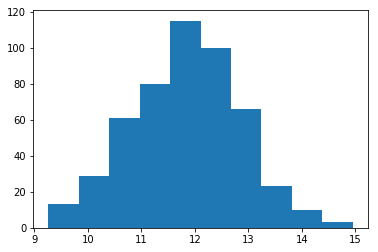

In [6]:
print(stats.mean(1))
print((stats>.95).float().mean(1))
print(auroc)
plt.hist(bounds)
plt.show()

In [7]:
device = torch.device('cuda:3')
dataset = 'FMNIST'

model_params = params.params_dict[dataset](augm_flag=True, batch_size=128)

file_joint = 'gmm__PCAFMNIST_lam0.0_n100_lr0.1_lrgmm1e-05_augm_flagTrue_train_typeCEDA_GMMgrad_vars mu var.pth'
file_base = 'base_FMNIST_lr0.1_augm_flagTrue_train_typeplain.pth'
file_CEDA = 'base_FMNIST_lr0.1_augm_flagTrue_train_typeCEDA.pth'
#file_ACET = 'base_FMNIST_lr0.001_augm_flagTrue_train_typeACET_steps40.pth'

model_joint = torch.load('SavedModels/' + file_joint).to(device)
base_model = torch.load('SavedModels/base/' + file_base).to(device)
CEDA_model = torch.load('SavedModels/base/' + file_CEDA).to(device)
ACET_model = torch.load('SavedModels/base/' + file_ACET).to(device)

shape = enumerate(model_params.test_loader).__next__()[1][0][0].shape
gmm = model_joint.mm
model_list = [base_model, CEDA_model, model_joint]
lam = model_joint.loglam.exp().item()

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `

In [8]:
stats, bounds = ev.aggregate_adv_stats(model_list, gmm, device, shape, classes=model_params.classes, 
                                       batches=batches, batch_size=batch_size, steps=steps, 
                                       restarts=restarts, alpha=alpha, lam=lam)
auroc = get_auroc(model_list, model_params, stats, device)

tensor([0.9520, 0.8553, 0.1000])
tensor([0.8640, 0.5080, 0.0000])
[0.30895730000000005, 0.9199856999999999, 0.9998]


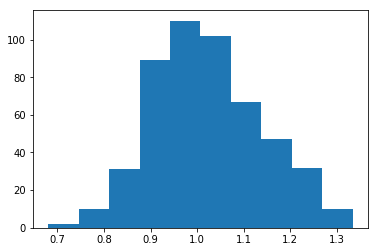

In [9]:
print(stats.mean(1))
print((stats>.95).float().mean(1))
print(auroc)
plt.hist(bounds)
plt.show()

In [10]:
device = torch.device('cuda:3')
dataset = 'SVHN'

model_params = params.params_dict[dataset](augm_flag=True, batch_size=128)

file_joint = 'gmm__PCASVHN_lam0.0_n100_lr0.1_lrgmm1e-05_augm_flagTrue_train_typeCEDA_GMMgrad_vars mu var.pth'
file_base = 'base_SVHN_lr0.1_augm_flagTrue_train_typeplain.pth'
file_CEDA = 'base_SVHN_lr0.1_augm_flagTrue_train_typeCEDA.pth'
#file_ACET = 'base_FMNIST_lr0.001_augm_flagTrue_train_typeACET_steps40.pth'

model_joint = torch.load('SavedModels/' + file_joint).to(device)
base_model = torch.load('SavedModels/base/' + file_base).to(device)
CEDA_model = torch.load('SavedModels/base/' + file_CEDA).to(device)
#ACET_model = torch.load('SavedModels/base/' + file_ACET).to(device)

shape = enumerate(model_params.test_loader).__next__()[1][0][0].shape
gmm = model_joint.mm
model_list = [base_model, CEDA_model, model_joint]
lam = model_joint.loglam.exp().item()

Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat


/usr/local/lib/python3.5/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `

In [11]:
stats, bounds = ev.aggregate_adv_stats(model_list, gmm, device, shape, classes=model_params.classes, 
                                       batches=batches, batch_size=batch_size, steps=steps, 
                                       restarts=restarts, alpha=alpha, lam=lam)
auroc = get_auroc(model_list, model_params, stats, device)

tensor([0.9510, 0.9806, 0.1000])
tensor([0.8460, 0.9140, 0.0000])
[0.28599400737553776, 0.6485958435771357, 1.0]


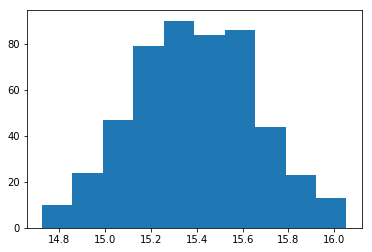

In [12]:
print(stats.mean(1))
print((stats>.95).float().mean(1))
print(auroc)
plt.hist(bounds)
plt.show()

In [13]:
device = torch.device('cuda:3')
dataset = 'CIFAR10'

model_params = params.params_dict[dataset](augm_flag=True, batch_size=128)

file_joint = 'gmm__PCACIFAR10_lam0.0_n100_lr0.1_lrgmm1e-05_augm_flagTrue_train_typeCEDA_GMMgrad_vars mu var.pth'
file_base = 'base_CIFAR10_lr0.1_augm_flagTrue_train_typeplain.pth'
file_CEDA = 'base_CIFAR10_lr0.1_augm_flagTrue_train_typeCEDA.pth'
#file_ACET = 'base_FMNIST_lr0.001_augm_flagTrue_train_typeACET_steps40.pth'

model_joint = torch.load('SavedModels/' + file_joint).to(device)
base_model = torch.load('SavedModels/base/' + file_base).to(device)
CEDA_model = torch.load('SavedModels/base/' + file_CEDA).to(device)
#ACET_model = torch.load('SavedModels/base/' + file_ACET).to(device)

shape = enumerate(model_params.test_loader).__next__()[1][0][0].shape
gmm = model_joint.mm 
model_list = [base_model, CEDA_model, model_joint]
lam = model_joint.loglam.exp().item()

Using downloaded and verified file: ../data/test_32x32.mat


/usr/local/lib/python3.5/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `

In [14]:
stats, bounds = ev.aggregate_adv_stats(model_list, gmm, device, shape, classes=model_params.classes, 
                                       batches=batches, batch_size=batch_size, steps=steps, 
                                       restarts=restarts, alpha=alpha, lam=lam)
auroc = get_auroc(model_list, model_params, stats, device)

tensor([0.9915, 0.1306, 0.1000])
tensor([0.9720, 0.0240, 0.0000])
[0.05567400000000003, 0.9824700999999999, 1.0]


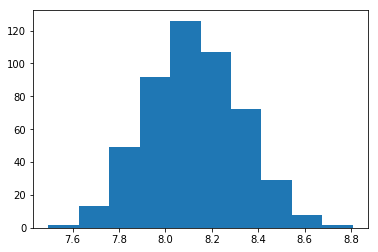

In [15]:
print(stats.mean(1))
print((stats>.95).float().mean(1))
print(auroc)
plt.hist(bounds)
plt.show()

In [16]:
device = torch.device('cuda:3')
dataset = 'CIFAR100'

model_params = params.params_dict[dataset](augm_flag=True, batch_size=128)

file_joint = 'gmm__PCACIFAR100_lam0.0_n100_lr0.1_lrgmm1e-05_augm_flagTrue_train_typeCEDA_GMMgrad_vars mu var.pth'
file_base = 'base_CIFAR100_lr0.1_augm_flagTrue_train_typeplain.pth'
file_CEDA = 'base_CIFAR100_lr0.1_augm_flagTrue_train_typeCEDA.pth'
#file_ACET = 'base_FMNIST_lr0.001_augm_flagTrue_train_typeACET_steps40.pth'

model_joint = torch.load('SavedModels/' + file_joint).to(device)
base_model = torch.load('SavedModels/base/' + file_base).to(device)
CEDA_model = torch.load('SavedModels/base/' + file_CEDA).to(device)
#ACET_model = torch.load('SavedModels/base/' + file_ACET).to(device)

shape = enumerate(model_params.test_loader).__next__()[1][0][0].shape
gmm = model_joint.mm
model_list = [base_model, CEDA_model, model_joint]
lam = model_joint.loglam.exp().item()

Using downloaded and verified file: ../data/test_32x32.mat


/usr/local/lib/python3.5/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `

In [17]:
stats, bounds = ev.aggregate_adv_stats(model_list, gmm, device, shape, classes=model_params.classes, 
                                       batches=batches, batch_size=batch_size, steps=steps, 
                                       restarts=restarts, alpha=alpha, lam=lam)
auroc = get_auroc(model_list, model_params, stats, device)

tensor([0.9117, 0.9219, 0.1000])
tensor([0.7180, 0.7480, 0.0000])
[0.43842089999999995, 0.42713, 0.998]


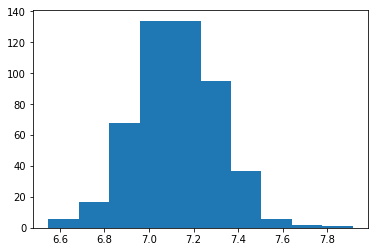

In [18]:
print(stats.mean(1))
print((stats>.95).float().mean(1))
print(auroc)
plt.hist(bounds)
plt.show()